In [1]:
# !pip install pyspark -qq
# !pip install tensorflowonspark -qq

In [2]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflowonspark import TFCluster
from sklearn.preprocessing import MinMaxScaler

import os.path
from os import path


# Khởi tạo Spark Session
spark = SparkSession.builder.appName("kafka").getOrCreate()
sc = spark.sparkContext
# Tạo DataFrame mẫu
train_data = spark.read.csv("../data/train_data.csv", inferSchema=True, header=True)
test_data = spark.read.csv("../data/test_data.csv", inferSchema=True, header=True)


In [3]:
len(train_data.toPandas())


2496

In [4]:
train_data.toPandas()

,time,open,high,low,close,volume,ticker
0,2013-01-02,16876,17407,16770,16982,106720,VIC
1,2013-01-03,16982,16982,16770,16982,118830,VIC
2,2013-01-04,16876,17088,16770,16982,162880,VIC
3,2013-01-07,17088,17831,17088,17725,370650,VIC
4,2013-01-08,17937,18044,17725,17937,363210,VIC
...,...,...,...,...,...,...,...
2491,2022-12-27,52900,53000,52300,52900,317300,VIC
2492,2022-12-27,52900,54800,52100,53400,1844000,VIC
2493,2022-12-28,53500,53500,52100,53500,2089000,VIC
2494,2022-12-29,53200,54000,52500,53600,2135400,VIC


In [5]:
training_set = train_data.select("close").toPandas().values
# Thuc hien scale du lieu gia ve khoang 0,1
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [6]:
# Tao du lieu train, X = 60 time steps, Y =  1 time step
def pre_process(data, data_scaled):
    X=[]
    y=[]
    no_of_sample = len(data)

    for i in range(60, no_of_sample):
        X.append(data_scaled[i-60:i, 0])
        y.append(data_scaled[i, 0])

    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

In [7]:
X_train, y_train = pre_process(training_set, training_set_scaled)

In [8]:
X_train.shape[1]

60

In [9]:
def init_model():
    regressor = Sequential()
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    return regressor

In [11]:
regressor = init_model()
if path.exists("../model/mymodel.h5"):
    regressor.load_weights("../model/mymodel.h5")
else:
    # Con khong thi train
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save("../model/mymodel.h5")

In [12]:
test_set = test_data.select("close").toPandas().values
a = training_set[len(training_set)-60:]
dataset_test = np.concatenate((a, test_set), axis=0)

test_scaled = scaler.transform(dataset_test)

In [13]:
X_test, y_test = pre_process(dataset_test, test_scaled)

In [15]:
model_load= init_model()
model_load.load_weights("../model/mymodel.h5")


In [16]:
a= regressor.predict(X_test)

8/8 [==============================] - 1s 14ms/step


In [17]:
scaler.inverse_transform(np.array(a))

array([[54748.39 ],
       [55632.098],
       [56497.19 ],
       [56903.97 ],
       [56915.242],
       [56491.676],
       [55845.316],
       [55459.77 ],
       [55335.805],
       [55294.566],
       [55187.363],
       [55151.074],
       [55581.73 ],
       [56352.54 ],
       [57466.473],
       [57964.68 ],
       [57706.75 ],
       [56773.81 ],
       [56006.02 ],
       [55752.86 ],
       [55802.   ],
       [55621.426],
       [55142.383],
       [54651.336],
       [54320.664],
       [54030.797],
       [53684.23 ],
       [53404.016],
       [53398.004],
       [53586.668],
       [53929.24 ],
       [54293.297],
       [54206.414],
       [53860.26 ],
       [53549.285],
       [53289.86 ],
       [53123.746],
       [53069.43 ],
       [53097.125],
       [53114.01 ],
       [53073.44 ],
       [53037.45 ],
       [53103.68 ],
       [53211.742],
       [53307.805],
       [53410.715],
       [53417.57 ],
       [53603.004],
       [53705.305],
       [53631.742],


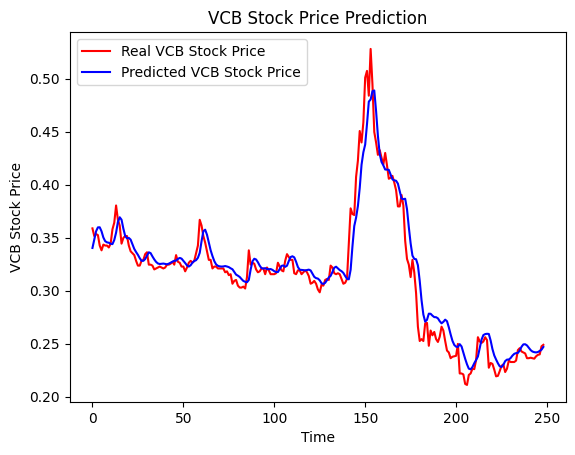

In [18]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(y_test, color = 'red', label = 'Real VCB Stock Price')
plt.plot(a, color = 'blue', label = 'Predicted VCB Stock Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
# plt.savefig('svm_result.jpg')
plt.show()


In [19]:
def predict_future(data):
    inputs = data
    # inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)
    # print(inputs)
    list_predict = []

    i = 0
    while i<28:
        X_test = []
        no_of_sample = len(data)

        # Lay du lieu cuoi cung
        X_test.append(inputs[no_of_sample - 60:no_of_sample, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        # print(X_test)
        # Du doan gia
        predicted_stock_price = regressor.predict(X_test)

        # chuyen gia tu khoang (0,1) thanh gia that
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

        # Them ngay hien tai vao
        data = np.concatenate((data, predicted_stock_price), axis=0)
        inputs = data
        # inputs = inputs.reshape(-1, 1)
        inputs = scaler.transform(inputs)

        list_predict.append(predicted_stock_price[0][0])

        # print('Stock price ' + str(i+3) + '/10/2019 of VCB : ', predicted_stock_price[0][0])
        i = i +1

    return list_predict

In [20]:
data_test = test_set[len(test_set)-28-60:len(test_set)-28]
y_pre=predict_future(data_test)

1/1 [==============================] - 0s 25ms/step


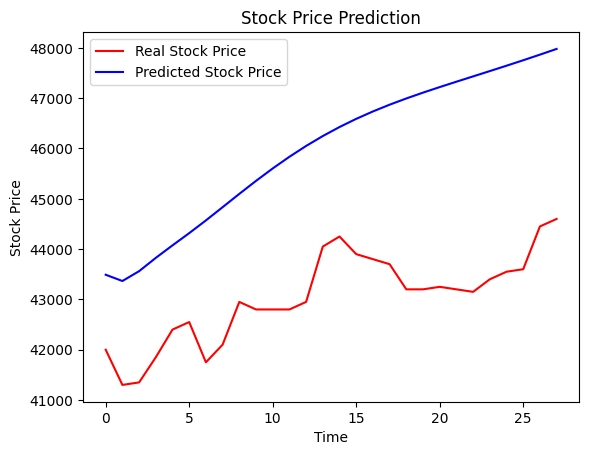

In [25]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(test_set[len(test_set)-28:], color = 'red', label = 'Real Stock Price')
plt.plot(y_pre, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('../static/LSTM_result_28.jpg')
plt.show()